In [1]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [3]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

In [4]:
# install for train and test
root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

In [5]:
print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


In [6]:
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [7]:
features = 784 # 28*28
classes = 10

In [8]:
W = torch.FloatTensor(features, classes).uniform_(-1, 1) / features**0.5
W.requires_grad_()

tensor([[-0.0153, -0.0282, -0.0279,  ..., -0.0305, -0.0129, -0.0224],
        [ 0.0221,  0.0251, -0.0300,  ...,  0.0167, -0.0096, -0.0100],
        [ 0.0043, -0.0003, -0.0306,  ...,  0.0319, -0.0076,  0.0268],
        ...,
        [ 0.0151,  0.0238,  0.0348,  ...,  0.0349,  0.0090, -0.0302],
        [-0.0204,  0.0294, -0.0177,  ...,  0.0252, -0.0180, -0.0196],
        [-0.0266, -0.0314,  0.0103,  ..., -0.0043,  0.0097, -0.0114]],
       requires_grad=True)

In [9]:
epochs = 3
lr=1e-2
history = []

In [10]:
from torch.nn.functional import cross_entropy

In [11]:
# ручной прогон 
for i in range(epochs):
    for x_batch, y_batch in train_loader:
        # load batches of data correctly
        x_batch = x_batch.reshape(x_batch.shape[0], -1)

        # compute loss (log loss a.k.a. cross entropy)
        logits = x_batch @ W
        probabilities = torch.exp(
            logits) / torch.exp(logits).sum(dim=1, keepdims=True)

        loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
        history.append(loss.item())

        # calc gradients
        loss.backward()

        # step of gradient descent
        grad = W.grad
        with torch.no_grad():
            W -= lr * grad
        W.grad.zero_()

    print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.19582213461399078
2,	 loss: 0.14150382578372955
3,	 loss: 0.12143423408269882


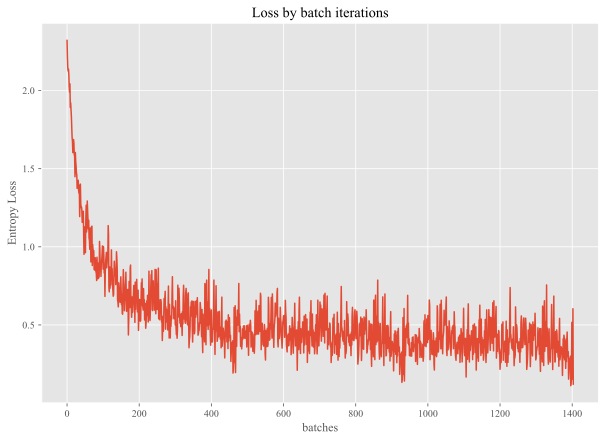

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(history)
plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')
plt.show()

In [13]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
    # load batches of data correctly
    batches += 1
    x_batch = x_batch.view(x_batch.shape[0], -1)
    y_batch = y_batch

    preds = torch.argmax(x_batch @ W, dim=1)
    acc += (preds == y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.901


In [14]:
y_batch

tensor([9, 8, 6, 7, 3, 4, 6, 8, 7, 0, 4, 2, 7, 7, 5, 4, 3, 4, 2, 8, 1, 5, 1, 0,
        2, 3, 3, 5, 7, 0, 6, 8, 6, 3, 9, 9, 8, 2, 7, 7, 1, 0, 1, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 7, 8, 9, 7, 8, 6, 4, 1, 9, 3, 8, 4,
        4, 7, 0, 1, 9, 2, 8, 7, 8, 2, 6, 0, 6, 5, 3, 3, 3, 9, 1, 4, 0, 6, 1, 0,
        0, 6, 2, 1, 1, 7, 7, 8, 4, 6, 0, 7, 0, 3, 6, 8, 7, 1, 5, 2, 4, 9, 4, 3,
        6, 4, 1, 7, 2, 6, 5, 0])

-------

In [36]:
import torch.nn as nn
from torchsummary import summary

In [37]:
model = nn.Sequential(
  nn.Linear(features, 64),
  nn.ReLU(),
  nn.Linear(64, classes),

)

# It is the same as:
#
# model = nn.Sequential()
# model.add_module('0', nn.Linear(features, 64))
# model.add_module('1', nn.Linear(64, classes))

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

In [38]:
summary(model, (features,), batch_size=228)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [228, 64]          50,240
              ReLU-2                  [228, 64]               0
            Linear-3                  [228, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 0.24
Params size (MB): 0.19
Estimated Total Size (MB): 1.12
----------------------------------------------------------------


In [39]:
criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) in its core, applied to logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [40]:
epochs = 3
history = []

In [41]:
for i in range(epochs):
    for x_batch, y_batch in train_loader:
        # 1. load batches of data correctly
        x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
        y_batch = y_batch.to(device)

        # 2. compute scores with .forward or .__call__
        logits = model(x_batch)

        # 3. compute loss
        loss = criterion(logits, y_batch)
        history.append(loss.item())

        # 4. calc gradients
        optimizer.zero_grad()
        loss.backward()

        # 5. step of gradient descent
        optimizer.step()

    print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.07504250854253769
2,	 loss: 0.056779541075229645
3,	 loss: 0.049958232790231705


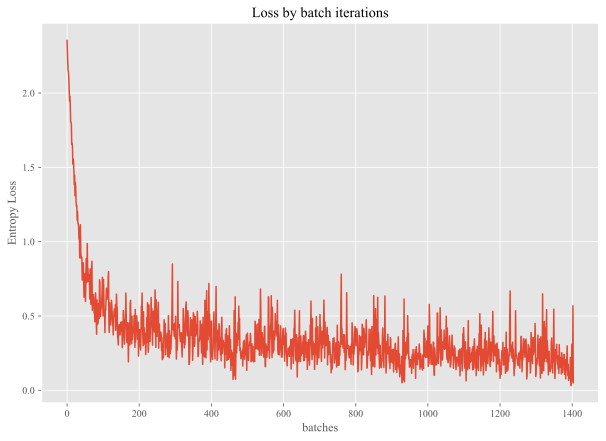

In [42]:
plt.figure(figsize=(10, 7))
plt.plot(history)
plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')
plt.show()

In [43]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
    # load batch of data correctly
    batches += 1
    x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
    y_batch = y_batch.to(device)

    preds = torch.argmax(model(x_batch), dim=1)
    acc += (preds == y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.938
